In [ ]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import get_typestore, Stores, get_types_from_msg
import pandas as pd

occluded_bag_path = "data/humble_occluded_run"
open_bag_path = "data/humble_open_run"
straight_line_bag_path = "data/humble_straight_line_run"
car_ride_bag_path = "data/car_ride"

typestore = get_typestore(Stores.ROS2_HUMBLE)

#register custom message
msg_text = open("gps_driver_msgs/msg/GpsMsg.msg").read()
add_types = get_types_from_msg(msg_text, "gps_driver_msgs/msg/GpsMsg")
typestore.register(add_types)


def bag_to_df(bag_path, typestore):
    rows = []

    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():

            if connection.topic != "/gps":
                continue

            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)

            rows.append({
                "bag_time_ns": int(timestamp),
                "stamp_sec": int(msg.header.stamp.sec),
                "stamp_nanosec": int(msg.header.stamp.nanosec),
                "frame_id": msg.header.frame_id,

                "latitude": float(msg.latitude),
                "longitude": float(msg.longitude),
                "altitude": float(msg.altitude),
                "hdop": float(msg.hdop),

                "utm_easting": float(msg.utm_easting),
                "utm_northing": float(msg.utm_northing),

                "utc": str(msg.utc),
                "zone": str(msg.zone),
                "letter": str(msg.letter),

                
            })

    return pd.DataFrame(rows)

# Read in data

In [ ]:
# remove start and end rows where it's not a straight line run
straight_line_df = bag_to_df(straight_line_bag_path, typestore)
straight_line_data = straight_line_df.iloc[285:440]
raw_straight_line_df = bag_to_df(straight_line_bag_path, typestore)

occluded_data = bag_to_df(occluded_bag_path, typestore)
open_data = bag_to_df(open_bag_path, typestore)


raw_car_ride_data = bag_to_df(car_ride_bag_path, typestore)
raw_car_ride_data.shape

straight_line_car_data = raw_car_ride_data.iloc[605:637]
car_ride_data = raw_car_ride_data.iloc[550:770].copy()



In [105]:
straight_line_df

,bag_time_ns,stamp_sec,stamp_nanosec,frame_id,latitude,longitude,altitude,hdop,utm_easting,utm_northing,utc,zone,letter
0,1770773547114725382,5547,0,GPS1_Frame,42.248572,-71.819945,178.9,1.09,267360.820510,4.681226e+06,013227.00,19,T
1,1770773548117707479,5548,0,GPS1_Frame,42.248578,-71.819942,178.0,1.22,267361.034473,4.681227e+06,013228.00,19,T
2,1770773549117036637,5549,0,GPS1_Frame,42.248582,-71.819943,177.6,1.22,267360.979817,4.681227e+06,013229.00,19,T
3,1770773550119663555,5550,0,GPS1_Frame,42.248585,-71.819943,177.4,1.22,267361.018964,4.681228e+06,013230.00,19,T
4,1770773551118187443,5551,0,GPS1_Frame,42.248584,-71.819946,178.0,1.09,267360.755249,4.681228e+06,013231.00,19,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,1770774100117118322,6100,0,GPS1_Frame,42.248599,-71.819970,167.0,1.13,267358.802811,4.681229e+06,014140.00,19,T
554,1770774101115309299,6101,0,GPS1_Frame,42.248600,-71.819969,167.6,1.13,267358.929019,4.681229e+06,014141.00,19,T
555,1770774102113127636,6102,0,GPS1_Frame,42.248596,-71.819965,167.7,1.13,267359.233026,4.681229e+06,014142.00,19,T
556,1770774103118645132,6103,0,GPS1_Frame,42.248596,-71.819959,168.4,1.13,267359.766852,4.681229e+06,014143.00,19,T


In [ ]:
r

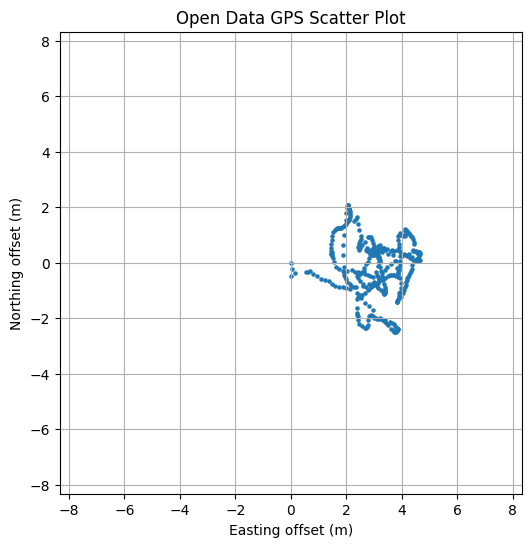

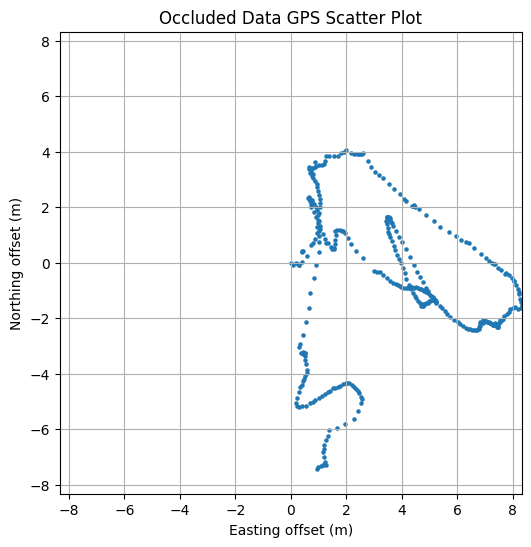

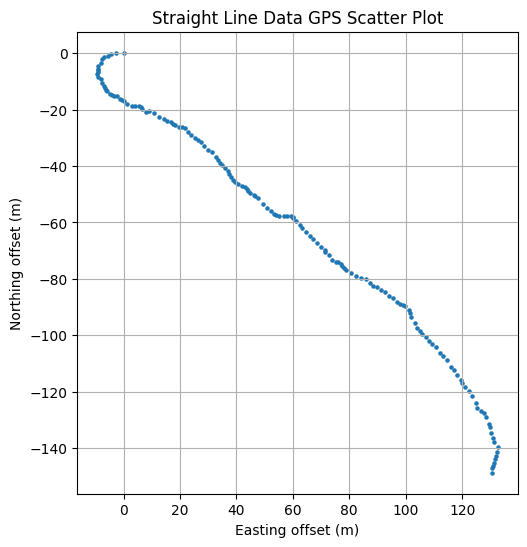

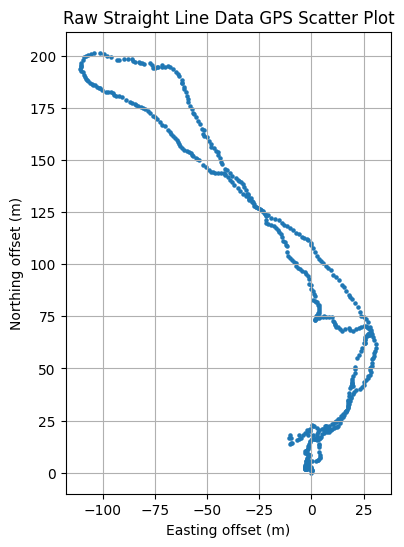

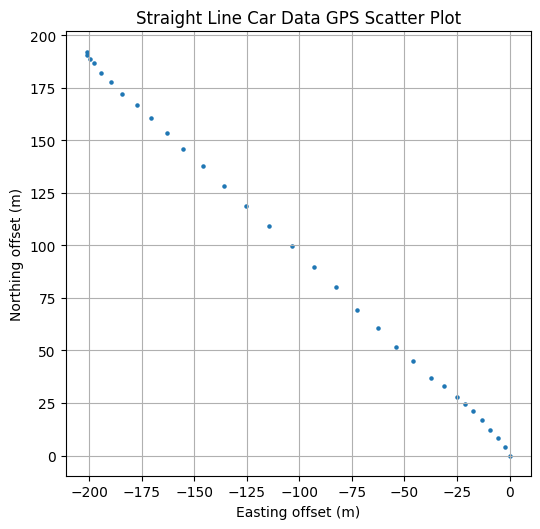

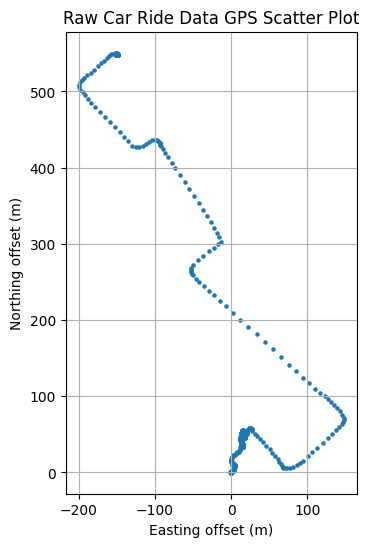

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_gps_scatter(df, title, lims=None):

    e = df['utm_easting'] - df['utm_easting'].iloc[0]
    n = df['utm_northing'] - df['utm_northing'].iloc[0]

    plt.figure(figsize=(6,6))
    plt.scatter(e, n, s=5)

    plt.xlabel('Easting offset (m)')
    plt.ylabel('Northing offset (m)')
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True)

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.show()


def get_limits(*dfs):
    all_e = []
    all_n = []

    for df in dfs:
        e = df['utm_easting'] - df['utm_easting'].iloc[0]
        n = df['utm_northing'] - df['utm_northing'].iloc[0]
        all_e.extend(e)
        all_n.extend(n)

    m = max(np.max(np.abs(all_e)), np.max(np.abs(all_n)))
    return (-m, m)

occluded_data = bag_to_df(occluded_bag_path, typestore)
open_data = bag_to_df(open_bag_path, typestore)
lims = get_limits(open_data, occluded_data)

plot_gps_scatter(open_data, 'Open Data GPS Scatter Plot', lims)
plot_gps_scatter(occluded_data, 'Occluded Data GPS Scatter Plot', lims)
plot_gps_scatter(straight_line_data, 'Straight Line Data GPS Scatter Plot')
plot_gps_scatter(raw_straight_line_df, 'Raw Straight Line Data GPS Scatter Plot')
plot_gps_scatter(straight_line_car_data, 'Straight Line Car Data GPS Scatter Plot')
plot_gps_scatter(raw_car_ride_data, 'Raw Car Ride Data GPS Scatter Plot')


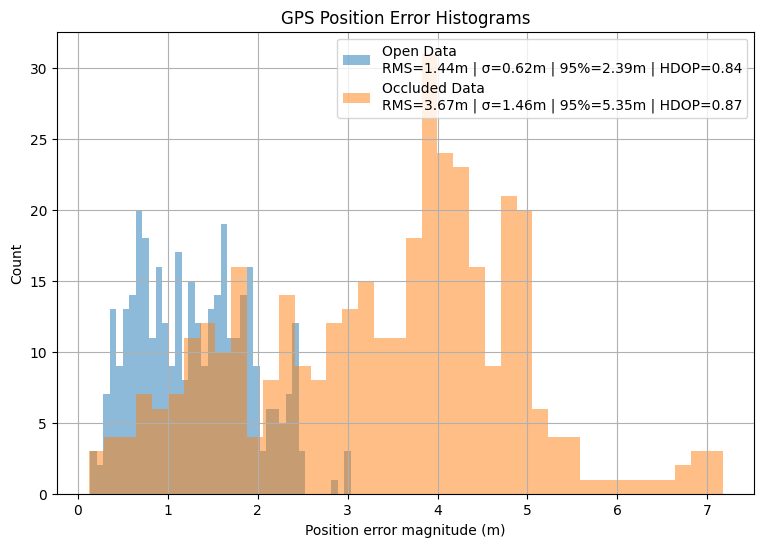

In [99]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_histograms(datasets, bins=40):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(9,6))

    for df, label in datasets:

        # known position = mean
        E_known = df['utm_easting'].mean()
        N_known = df['utm_northing'].mean()

        dE = df['utm_easting'] - E_known
        dN = df['utm_northing'] - N_known
        error = np.sqrt(dE**2 + dN**2)

        # stats
        rms = np.sqrt((error**2).mean())
        std = error.std()
        p95 = np.percentile(error, 95)
        hdop = df['hdop'].mean()

        legend_label = (
            f"{label}\n"
            f"RMS={rms:.2f}m | σ={std:.2f}m | 95%={p95:.2f}m | HDOP={hdop:.2f}"
        )

        plt.hist(error, bins=bins, alpha=0.5, label=legend_label)

    plt.xlabel("Position error magnitude (m)")
    plt.ylabel("Count")
    plt.title("GPS Position Error Histograms")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_error_histograms([
    (open_data, 'Open Data'),
    (occluded_data, 'Occluded Data'),
])


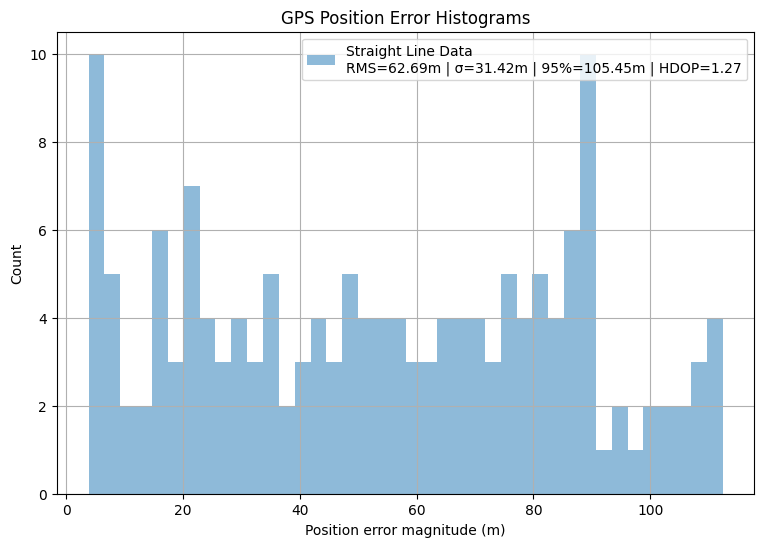

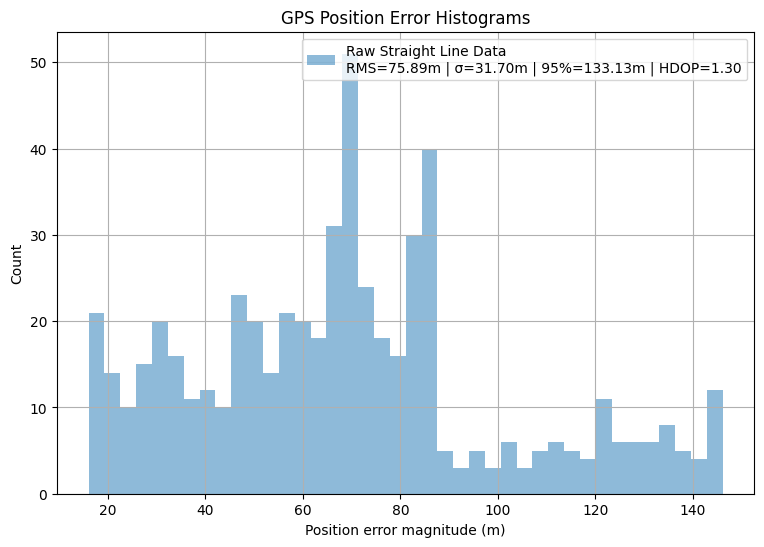

In [100]:
plot_error_histograms([
    (straight_line_data, 'Straight Line Data'),
])

plot_error_histograms([
    (raw_straight_line_df, 'Raw Straight Line Data'),
])

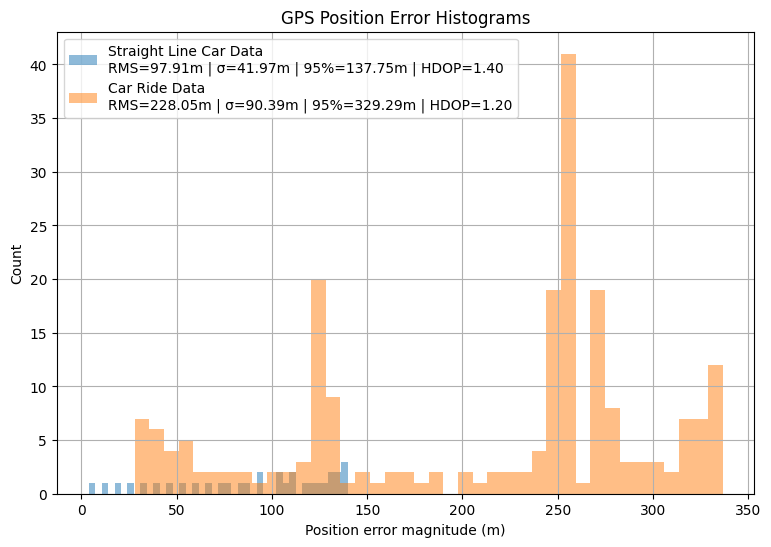

In [101]:
plot_error_histograms([
    (straight_line_car_data, 'Straight Line Car Data'),
    (car_ride_data, 'Car Ride Data'),
])

In [116]:
def plot_altitude_vs_time_all(datasets):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(10,5))

    for df, label in datasets:

        t = (df['bag_time_ns'] - df['bag_time_ns'].iloc[0]) / 1e9
        
        alt = df['altitude']

        plt.scatter(t, alt, label=label, s=5)   # line is nicer than scatter here

    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (m)")
    plt.title("Altitude vs Time Comparison")
    plt.legend()
    plt.grid(True)

    plt.show()


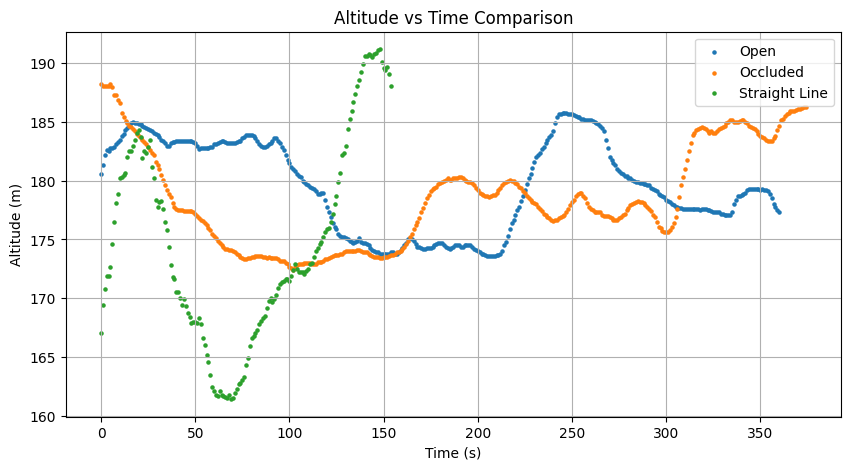

In [117]:
plot_altitude_vs_time_all([
    (open_data, "Open"),
    (occluded_data, "Occluded"),
    (straight_line_data, "Straight Line"),
])


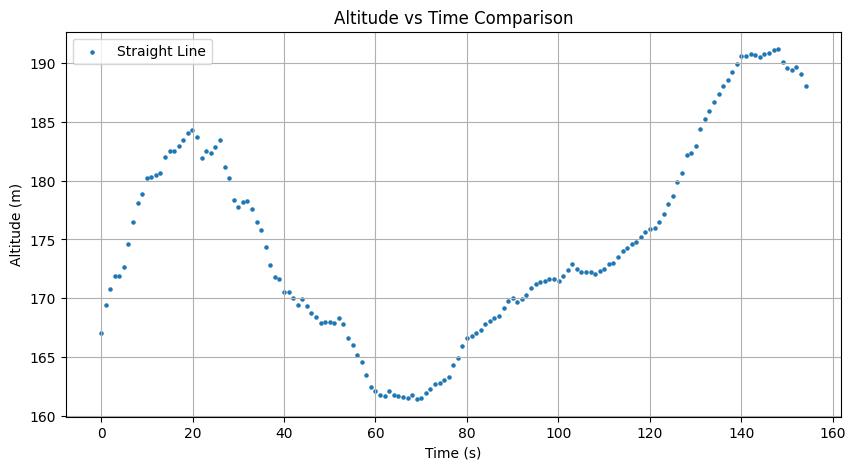

In [119]:

plot_altitude_vs_time_all([
    (straight_line_data, "Straight Line")
])


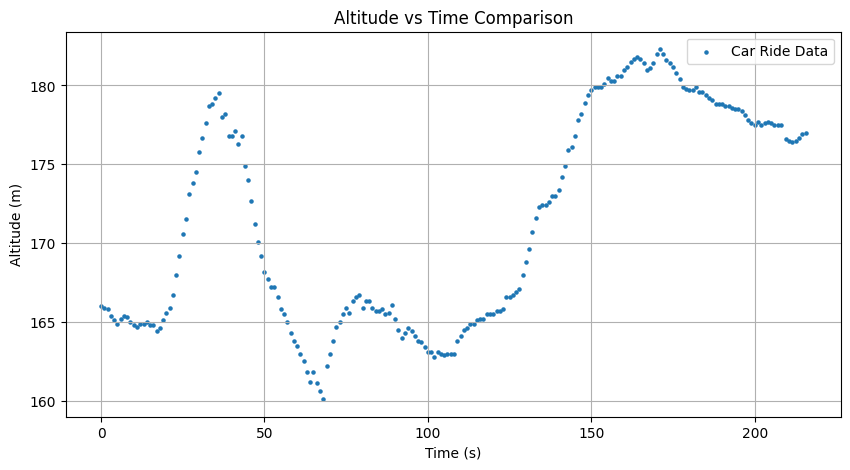

In [120]:
plot_altitude_vs_time_all([
    (car_ride_data, "Car Ride Data")
])

Distance along best-fit line: 200.74 m


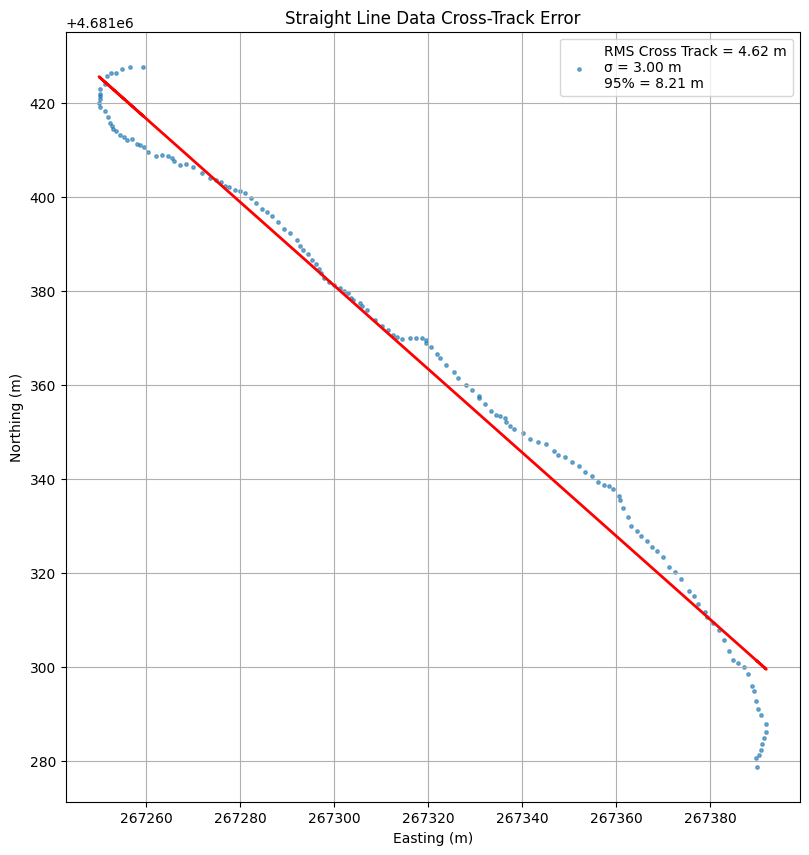

array([ 7.67200684,  6.03053388,  4.55480277,  3.07994126,  2.24312386,
        1.17440464,  0.36053309,  1.7690405 ,  2.582291  ,  2.93299321,
        3.4316162 ,  4.15726362,  4.61923225,  4.61870037,  5.12403542,
        5.75000571,  5.91130283,  6.28141831,  6.2650944 ,  6.30759056,
        6.11972982,  6.0958237 ,  5.17231885,  5.28788065,  5.04878107,
        4.91182091,  5.02100778,  4.51281699,  3.58477126,  2.78706719,
        2.5655453 ,  2.77836874,  2.63507875,  1.58093986,  1.15001652,
        0.82248473,  0.37460763,  0.12938257,  0.48303727,  0.52056651,
        0.83968994,  1.2078827 ,  1.72795385,  2.11526807,  2.10972513,
        2.06781726,  1.98771123,  2.09130825,  2.15883151,  2.04265267,
        1.89585731,  2.21040089,  1.95963368,  1.52249815,  1.33846358,
        1.22382811,  0.98430883,  0.84784638,  0.55409108,  0.12849481,
        0.20345831,  0.14047191,  0.08294212,  0.35436497,  0.60801058,
        0.69798994,  0.4130255 ,  0.33933863,  0.83817296,  0.71

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_fit_error(df, title):

    E = df['utm_easting'].values
    N = df['utm_northing'].values

    # ---- fit line ----
    m, b = np.polyfit(E, N, 1)
    N_fit = m*E + b

    # ---- perpendicular distance (cross-track error) ----
    error = np.abs(m*E - N + b) / np.sqrt(m**2 + 1)

    # stats
    rms = np.sqrt((error**2).mean())
    std = error.std()
    p95 = np.percentile(error, 95)

    # ---- plot ----
    plt.figure(figsize=(10,10))

    plt.scatter(E, N, s=6, alpha=0.6)

    legend_label = (
        
        f"RMS Cross Track = {rms:.2f} m\n"
        f"σ = {std:.2f} m\n"
        f"95% = {p95:.2f} m"
    )

    plt.plot(E, N_fit, 'r', linewidth=2)

    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title(title)
    plt.legend([legend_label])
    plt.gca().set_aspect('equal')
    plt.grid(True)

    plt.show()

    return error

def distance_along_best_fit_line(df):
    E = df["utm_easting"].to_numpy()
    N = df["utm_northing"].to_numpy()

    # Fit N = mE + b
    m, b = np.polyfit(E, N, 1)

    # Unit direction vector along the line: [1, m] normalized
    u = np.array([1.0, m])
    u = u / np.linalg.norm(u)

    # Project each point onto u (dot product)
    P = np.column_stack([E, N])
    s = P @ u  # scalar position along the line

    # distance traveled along line (range of projections)
    return float(s.max() - s.min()), m, b

dist_along, m, b = distance_along_best_fit_line(straight_line_data)
print(f"Distance along best-fit line: {dist_along:.2f} m")


plot_line_fit_error(straight_line_data, "Straight Line Data Cross-Track Error")

Distance along best-fit line: 590.55 m


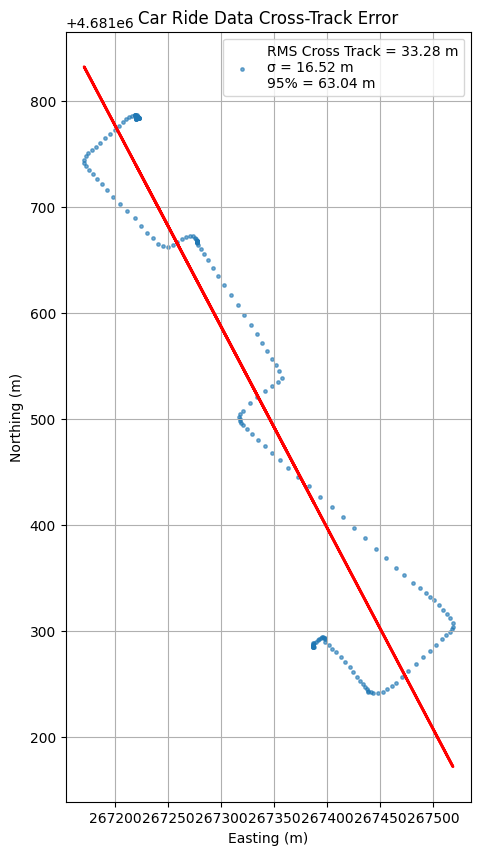

array([63.89633443, 63.94444859, 63.92002212, 64.03233188, 64.1665907 ,
       64.11825926, 64.07879438, 64.04963034, 63.67806065, 63.36986079,
       62.98633865, 62.20951523, 61.03269726, 59.54120363, 57.33769125,
       55.84732809, 53.63268981, 52.36386044, 51.42826549, 50.94925367,
       50.68373453, 50.58524524, 51.69151848, 50.2619101 , 48.98346372,
       47.16323897, 45.32179537, 44.03789537, 42.31792114, 41.47759739,
       40.48115348, 39.45111069, 38.66742453, 38.12144427, 37.61419801,
       37.93837518, 37.95909488, 35.91107734, 34.24483098, 30.0320506 ,
       25.77176704, 20.68303668, 15.35617943, 10.45353714,  2.78458312,
        4.83933668, 13.73517156, 23.15876898, 31.68519197, 39.45777207,
       46.58634988, 52.26660141, 56.61249075, 59.77012971, 61.63411037,
       63.1769183 , 62.9962954 , 62.29388683, 60.83909101, 59.37338052,
       57.50994506, 55.91678161, 54.10352897, 50.86743764, 47.39518518,
       43.72515159, 39.57887858, 36.00576143, 31.42237252, 27.62

In [122]:


dist_along, m, b = distance_along_best_fit_line(car_ride_data)

print(f"Distance along best-fit line: {dist_along:.2f} m")

plot_line_fit_error(car_ride_data, "Car Ride Data Cross-Track Error")

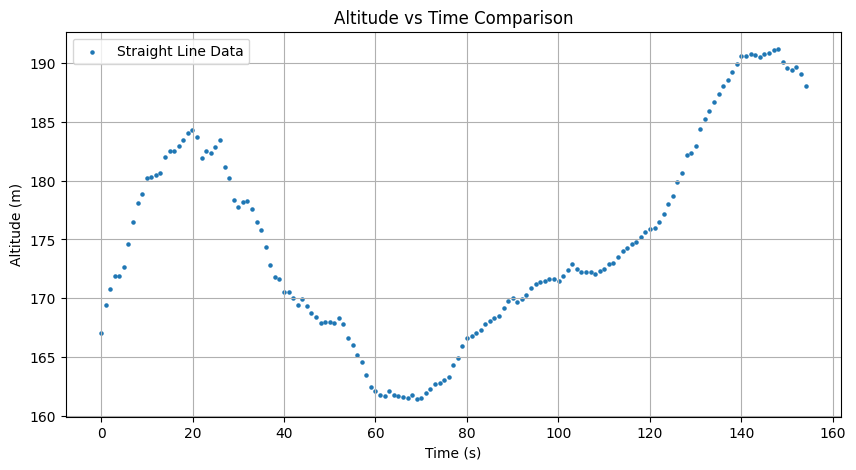

In [123]:
# plot altitude vs time for straight line data
plot_altitude_vs_time_all([
    (straight_line_data, "Straight Line Data"),
])

In [95]:
f

NameError: name 'f' is not defined